## Benchmarking the promoter sequences of the CRISPROff Screen

In [1]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests

n_sequences = 20883

In [ ]:
curl --upload-file 3kb_Promoter.sequences-greater0.csv https://transfer.sh


srun --pty -A co_nilah -p savio -t 02:00:00 bash -i

### Import Sequences from server

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(threshold=sys.maxsize)

#### Get the sequences from the server



In [1096]:
pp = pprint.PrettyPrinter()

b = []

for i, x in enumerate(Data['gene']):
    try:
        datas = requests.get('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 3'"][i]-1500))+'-'+str(Data["Primary TSS, 3'"][i]+1500)).text.replace('\n','')    
        b.append(Data['gene'][i])
        b.append(datas)
    except:
        print('There was an error with:',Data['gene'][i],'. With coordinates:', Data['chromosome'][i], Data["Primary TSS, 3'"][i])

#It took 106 minutes to comlpete all the sequences for 2.5 kb, but this run was with 3 kb

Promoter_sequences = pd.DataFrame()

for i in range(len(b)):
    Promoter_sequences[i] = pd.DataFrame(b)

Promoter_sequences = pd.DataFrame(b[::2], columns= ['Gene'])
Promoter_sequences['Sequences'] = b[1::2]

Promoter_sequences

Promoter_sequences.to_csv(r'3kb_Promoter.sequences-2.csv') # this was done after the sequences were updated with the actual TSS

There was an error with: DHX15 . With coordinates: chr4 24529088
There was an error with: SPATA25 . With coordinates: chr20 44515130
There was an error with: SPG20 . With coordinates: chr13 36920574


### Load the ~20,000 Sequences previosly extracted

At the end of the screen, there is less sgRNA, it's an indirect readout of effective gene silencing

In [2]:
TSS_coordinates = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
TSS_coordinates = TSS_coordinates.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
UCSC_TSS = pd.read_csv('UCSC_TSS.txt', delimiter = '\t',header = 0)
UCSC_TSS = UCSC_TSS.drop_duplicates() 

errors = []

for gene in (TSS_coordinates['gene']):
        try:
                if len(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - TSS_coordinates[TSS_coordinates['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        TSS_coordinates.loc[TSS_coordinates['gene'] == gene, "Primary TSS, 3'"] = (int(TSS_coordinates[TSS_coordinates['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
                else:
                        x = UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"].iloc[-1]
                        TSS_coordinates.loc[TSS_coordinates['gene'] == gene, "Primary TSS, 3'"] = int(x) + 1 
              

        except:
            errors.append(gene)

len(errors)

TSS_coordinates = TSS_coordinates.reset_index()

Promoter sequences merged with the start of the TSS Coordinates 

In [3]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences-2.csv', sep=',', header = 0)
#Promoter_sequences  = pd.concat([Promoter_sequences, Data], axis =1, join="inner")
#Promoter_sequences = Promoter_sequences.drop_duplicates(subset = 'Gene')
Promoter_sequences = pd.merge(how = 'outer', left = Promoter_sequences, right = TSS_coordinates, left_on = 'Gene', right_on = 'gene')
Promoter_sequences = Promoter_sequences.dropna()

### Load data from supplemental figures of paper

Table S3. A list of sgRNA protospacer sequences and calculated phenotype scores from the genome-wide CRISPRoff screens, related to Figure 4.

This is the Dataframe with the CRISPRoff average phenotype score


In [4]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

##### Only phenotype scores within the -0,2, 0.2 window

(-0.8, 0.2, -0.8, 0.2)

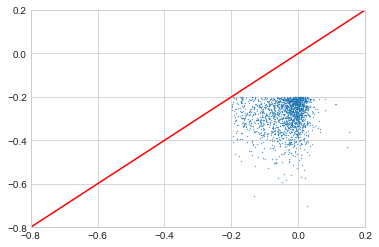

In [8]:
cpgs = cpgs[cpgs.CRISPRoff_average < -0.2]
cpgs = cpgs[cpgs.mutant_average > -0.2 ]

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(cpgs['mutant_average'], cpgs['CRISPRoff_average'],s = 0.1)

         
plt.axis([-0.8,0.2,-0.8,0.2])
x = [-1,-1,1,1]
y = x
plt.plot(x,y, 'r')
         
plt.axis([-0.8,0.2,-0.8,0.2])




### Description of the file

At the end of the screen, there is less sgRNA, it's an indirect readout of effective gene silencing

Phenotypes that are more negative means that they are dying from the population more than those that are closer to 0
so if a gene has the same phenotype in the CRoff screen and the mutant screen, then that gene will be on the diagonal of that plot
and thus, the effect is not bc of DNA methylation
it’s because of transient gene silencing from the KRAB domain
it’s a loose association, but the more negative the phenotype score, the better CRoff works

In [6]:
# Only select a single value per gene, to prevent duplicates

cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

cpgs.head()

,gene,CRISPRoff_average,mutant_average
3909,43891,-0.093578,0.302824
5409,43892,-0.054598,-0.029486
2475,43893,-0.163893,-0.118948
1178,43894,-0.250121,-0.110483
11969,43895,-0.005910,-0.020265


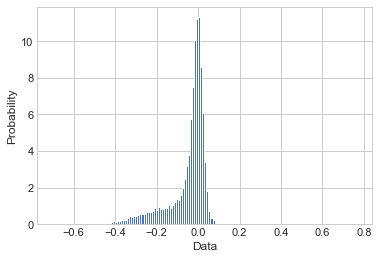

In [125]:
plt.hist(cpgs['CRISPRoff_average'], density=True, bins=150)  # density=False would make counts
plt.ylabel('Probability')

plt.xlabel('Data')

### Merging sequences with correspondent phenotype scores

In [89]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]

### Computing a Phenotype score that takes into account both relationships in CRISPRoff and mutants

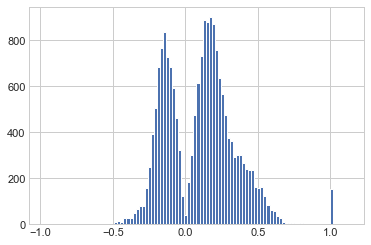

18902


In [90]:
import matplotlib.pyplot as plt
from math import sqrt

df['computed'] =  df['mutant_average']/ df['CRISPRoff_average'] 

for i in range(len(df)):

    if df['mutant_average'][i] > df['CRISPRoff_average'][i]:
        df.at[i, 'Phe_sco_pos_neg'] =  int(1)
        df.at[i,'Strength'] =  sqrt(abs(df['mutant_average'][i] - df['CRISPRoff_average'][i])) 

    elif df['mutant_average'][i] < df['CRISPRoff_average'][i]:
        df.at[i, 'Phe_sco_pos_neg'] = int(0)
        df.at[i,'Strength'] = -sqrt(abs(df['mutant_average'][i] - df['CRISPRoff_average'][i])) 
    else:
        df.at[i, 'Strength'] = 1

df = df[df.Strength < 10]
df = df[df.Strength > -10]

plt.hist(df.Strength, bins = 100)
plt.show()

print(len((df.Strength)))

#df.computed.describe()

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/1880597804.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


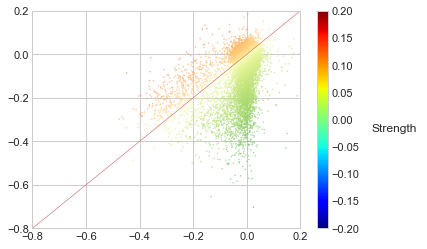

In [91]:
plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c =df.Strength, cmap = "RdYlGn", s= 0.1)

normalize = mcolors.Normalize(vmin= -0.2, vmax=0.2)
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.Strength)
plt.colorbar(scalarmappaple)
plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="Strength",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.axis([-0.8,0.2,-0.8,0.2])
x = [-1,-1,1,1]
y = x
plt.plot(x,y, 'r', linewidth = 0.5)
         

plt.savefig('computed-heritage.eps', format = 'eps', bbox_inches='tight')

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/200900098.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3456


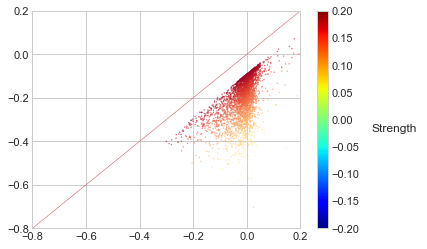

In [96]:
df = df[df.Strength > 0.3]

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c =df.Strength, cmap = "RdYlGn", s= 0.1)

normalize = mcolors.Normalize(vmin= -0.2, vmax=0.2)
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.Strength)
plt.colorbar(scalarmappaple)
plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="Strength",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.axis([-0.8,0.2,-0.8,0.2])
x = [-1,-1,1,1]
y = x
plt.plot(x,y, 'r', linewidth = 0.5)
         
plt.savefig('computed-heritage.eps', format = 'eps', bbox_inches='tight')


df_tmp = df[['Gene', 'Sequences']]
df_tmp.to_csv(r'sequences-03.csv') # this was done after the sequences were updated with the actual TSS

print(len(df.Sequences))

### Benchmarking for GC Content

In [12]:
df['GC'] = df.Sequences.apply(lambda x: (x.count('G') + x.count('C'))/30)
#df['GC'] = df['GC'].apply(lambda x: 0 if x < 50 else x)

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/2505643570.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


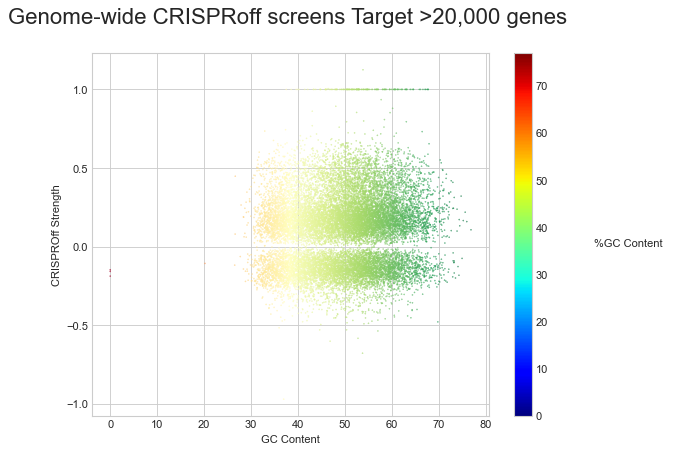

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.pyplot import figure

plt.style.use('seaborn-whitegrid')

figure(figsize=(8, 6), dpi=80)

plt.scatter( df.GC, df['Strength'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="%GC Content",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('GC Content')
plt.ylabel('CRISPROff Strength')

#plt.axis([-0.8,0.2,-0.8,0.2])
plt.subplots_adjust(top=0.88)
plt.savefig('Genome-wide Strength vs %GC.eps', format = 'eps', bbox_inches='tight')


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/2836349187.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)


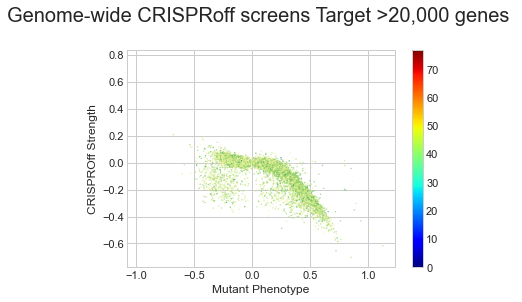

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['Strength'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Strength')

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Strength')

#plt.axis([-0.2,0.2,-0.2,0.1])
plt.savefig('Genome-Wide %GC Strength Zoom.eps', format = 'eps')


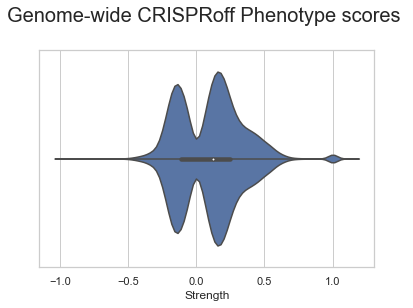

In [17]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)
ax = sns.violinplot(x=df['Strength'])
plt.savefig('Violin plot.eps', format = 'eps')

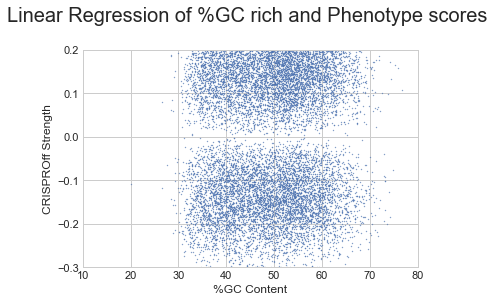

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter( df['GC'],df['Strength'], cmap = "RdYlGn",s = 0.1)

plt.ylabel('CRISPROff Strength')
plt.xlabel('%GC Content')

plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)

plt.axis([10,80,-0.3,0.2,])
plt.savefig('Linear-regression_1.eps', format = 'eps', bbox_inches='tight')


### Linear Regression of the phenotype scores with their %GC

coefficient of determination: 0.007337327389246973
slope: [0.00226786]
intercept: -0.011610833755298894


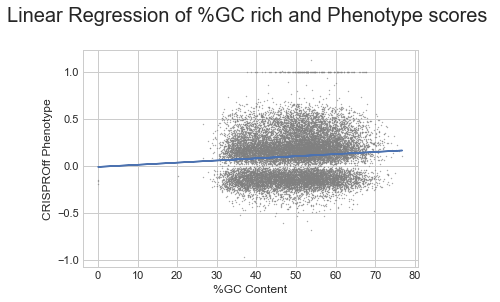

In [20]:
regression_data = df[['Strength','GC']].dropna()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

x =  np.array(regression_data.GC).reshape((-1,1))
y =  np.array(regression_data.Strength)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.GC),y,1)

print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter( df['GC'],df['Strength'],s = 0.1, c = 'grey')

plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)
plt.ylabel('CRISPROff Phenotype')
plt.xlabel('%GC Content')
plt.plot(x, m*x + b)

#plt.axis([-0.75,1,10,80])
plt.savefig('linear-regression_line.eps', format = 'eps',bbox_inches='tight')


In [21]:
Cpgs_TSS = [False, True]

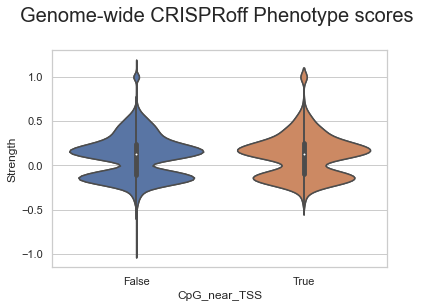

In [23]:
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = df, x= 'CpG_near_TSS', y = 'Strength', split=True)

plt.savefig('Violin plot.eps', format = 'eps')



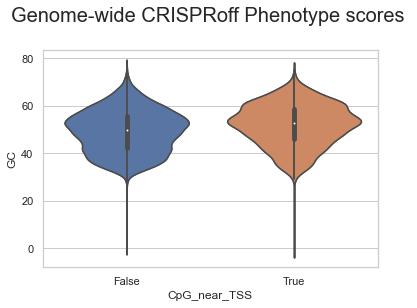

In [24]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = df, x= 'CpG_near_TSS', y = 'GC', split=True)

#plt.savefig('Violin plot.eps', format = 'eps')



### KMERs and GC 


In [25]:
kmer_length = 2

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [26]:
from collections import Counter

def Count_kmer(a_table, gc_elements, kmer):

    sequence = getKmers(str(a_table), kmer)

    gc_kmers = []
    gc_counts = Counter(sequence)

    for index, element in enumerate(gc_elements):

        if element in (dict(gc_counts)):
            gc_kmers.append((dict(gc_counts)[gc_elements[index]]))
        
        else:
            gc_kmers.append(0)
            #print(element, 'not in kmers')
            
    return(sum(gc_kmers)/3000*100)

#Promoter_sequences['kmers'] = Promoter_sequences.Sequences.apply(lambda x: Count_kmer(x, ['gg','cc','gc','cg'], 2))

Sequences_GC_kmers = [Count_kmer(i, ['gc','cg'], 2) for i in Promoter_sequences.Sequences]

df['kmer_count'] = Sequences_GC_kmers

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/739933203.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


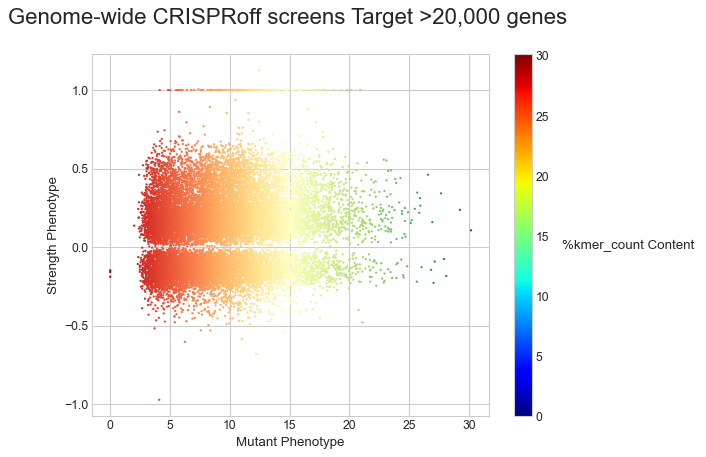

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.pyplot import figure

plt.style.use('seaborn-whitegrid')

figure(figsize=(8, 6), dpi=80)

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['kmer_count'], df['Strength'], c = df.kmer_count, cmap = "RdYlGn",s = 1)

normalize = mcolors.Normalize(vmin=df.kmer_count.min(), vmax=df.kmer_count.max())
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.kmer_count)
plt.colorbar(scalarmappaple)

plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="%kmer_count Content",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('Strength Phenotype')

#plt.axis([-0.8,0.2,-0.8,0.2])
plt.savefig('Genome-wide %kmer_count.eps', format = 'eps')


coefficient of determination: 0.011007552667088638
slope: [0.00599548]
intercept: 0.046231052528071456


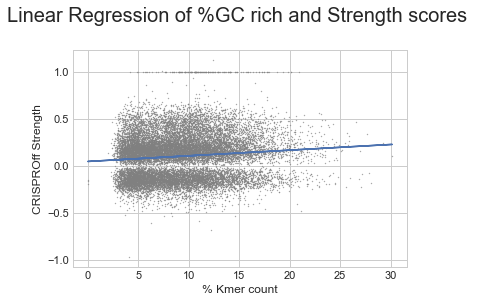

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

regression_data = df[['Strength','kmer_count']].dropna()

x =  np.array(regression_data.kmer_count).reshape((-1,1))
y =  np.array(regression_data.Strength)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.kmer_count),y,1)

print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df.kmer_count, df.Strength,s = 0.1, c = 'grey')

plt.title('Linear Regression of %GC rich and Strength scores \n', size = 20)
plt.ylabel('CRISPROff Strength')
plt.xlabel('% Kmer count')
plt.plot(x, m*x + b)

plt.savefig('Kmer-counts-2.eps', format = 'eps', bbox_inches='tight')


##### Kmer = 3

In [22]:
kmer_length = 3

Sequences_GC_kmers = [Count_kmer(i, ['gcg','gcc','ggc','cgc','ccg','cgg'], 3) for i in Promoter_sequences.Sequences]

df['kmer_count'] = Sequences_GC_kmers

### Essential Genes list across cell types

Those genes are the ‘common essential’ genes across many cell types, we predict all of those genes to cause cell death if you turn them off
so one good place to start is for those genes, get the CRISPRoff phenotypes from our paper almost all of them should be negative phenotypes
for those that are not, use some model to predict why is it bc they lack cpg islands?

In [29]:
achilles = pd.read_csv('Achilles_common_essentials.csv',sep = '(',  header = 0)
achilles_scores = pd.merge(how = 'inner', left = achilles, right = df, left_on = 'genes', right_on = 'Gene')
achilles_scores.genes = achilles_scores.genes.apply(lambda x: 1 if str(x) != 'nan' else 0)

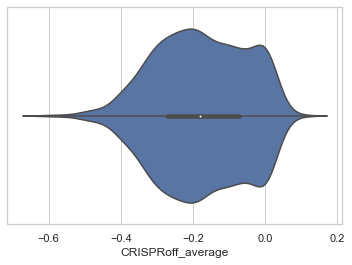

In [82]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=achilles_scores['CRISPRoff_average'])
plt.savefig('Essential Genes list.eps', format = 'eps')

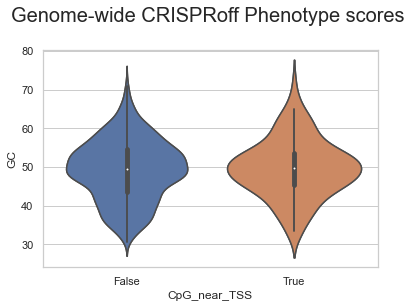

In [30]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = achilles_scores, x= 'CpG_near_TSS', y = 'GC', split=True)

#plt.savefig('Violin plot.eps', format = 'eps')



(-0.8, 0.2, -0.8, 0.2)

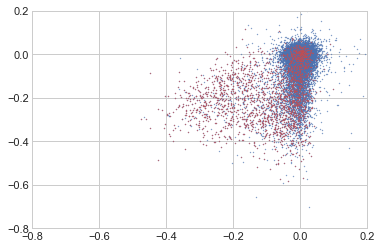

In [31]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'],s = 0.1)
plt.scatter(achilles_scores['mutant_average'], achilles_scores['CRISPRoff_average'],s = 0.1, c = 'r')

plt.axis([-0.8,0.2,-0.8,0.2])

In [32]:
achilles_cpgs = pd.merge(how = 'inner', left = achilles_scores, right = cpgs, left_on = 'Gene', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_41833/310466158.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gene_x'} in the result is deprecated and will raise a MergeError in a future version.
  achilles_cpgs = pd.merge(how = 'inner', left = achilles_scores, right = cpgs, left_on = 'Gene', right_on = 'gene')


In [33]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average','CpG']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
#cpgs['CpG'] = cpgs['CpG'].apply(lambda x:  1 if 'VERDADERO' else 0)

In [34]:
achilles_cpgs = achilles_cpgs.drop(['gene_x', 'index','transcript','strand','thres'], axis=1)

In [36]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm

# sns.violinplot(y='CRISPRoff_average_x', x="CpG",
#               data=achilles_cpgs)

# print('Genes without CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'FALSO']))
# print('Genes with CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'VERDADERO']))

# plt.savefig('Essential Genes list violin.eps', format = 'eps')

ValueError: Could not interpret input 'CpG'

### IRRBS File

This track is produced as part of the ENCODE project. The track displays the methylation status of specific CpG dinucleotides in the given cell types as identified by the Illumina Infinium Human Methylation 450 Bead Array platform. In general, methylation of CpG sites within a promoter causes silencing of the gene associated with that promoter.

The Infinium Human Methylation 450 platform uses bisulfite treated genomic DNA to assay the methylation status of more than 450,000 CpG sites covering all designatable RefSeq genes, including promoter, 5' and 3' regions, without bias against those lacking CpG islands. Additionally, the assay includes CpG islands and shores, CpG sites outside of CpG islands, non-CpG methylated sites identified in human stem cells, differentially methylated sites identified in tumor versus normal (multiple forms of cancer) and across several tissue types, CpG islands outside of coding regions, miRNA promoter regions, and disease-associated regions identified through GWAS.

In [39]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep='\t', header = 0)
irbs

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
0,chr1,1000170,1000171,K562_Rep3_RRBS,46,+,1000170,1000171,"155,255,0",46,35
1,chr1,1000190,1000191,K562_Rep3_RRBS,46,+,1000190,1000191,"105,255,0",46,15
2,chr1,1000191,1000192,K562_Rep3_RRBS,53,-,1000191,1000192,"55,255,0",53,9
3,chr1,1000198,1000199,K562_Rep3_RRBS,46,+,1000198,1000199,"105,255,0",46,20
4,chr1,1000199,1000200,K562_Rep3_RRBS,53,-,1000199,1000200,"105,255,0",53,15
...,...,...,...,...,...,...,...,...,...,...,...
1275813,chrY,9930847,9930848,K562_Rep3_RRBS,28,-,9930847,9930848,"205,255,0",28,43
1275814,chrY,9930879,9930880,K562_Rep3_RRBS,28,-,9930879,9930880,"255,155,0",28,68
1275815,chrY,9982886,9982887,K562_Rep3_RRBS,5,+,9982886,9982887,"0,255,0",5,0
1275816,chrY,9987654,9987655,K562_Rep3_RRBS,7,+,9987654,9987655,"55,255,0",7,14


In [35]:
irbs.columns

Index(['track', 'name="SL725', 'MspIRRBS"', 'K562_Rep3_RRBS', 'MspIRRBS".1',
       'visibility=2', 'name="SL725.1', 'MspIRRBS".2', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

#### Extract all the color values for each of the basepairs [figure]

In [36]:
col = irbs['Unnamed: 8'].str.split(',')

for i, x  in enumerate(col):
   col[i] = pd.to_numeric(col[i])/255

KeyboardInterrupt: 

Text(0.5, 1.0, 'DNA Methylation in Chromosomes for K562 hg19 bed file \n')

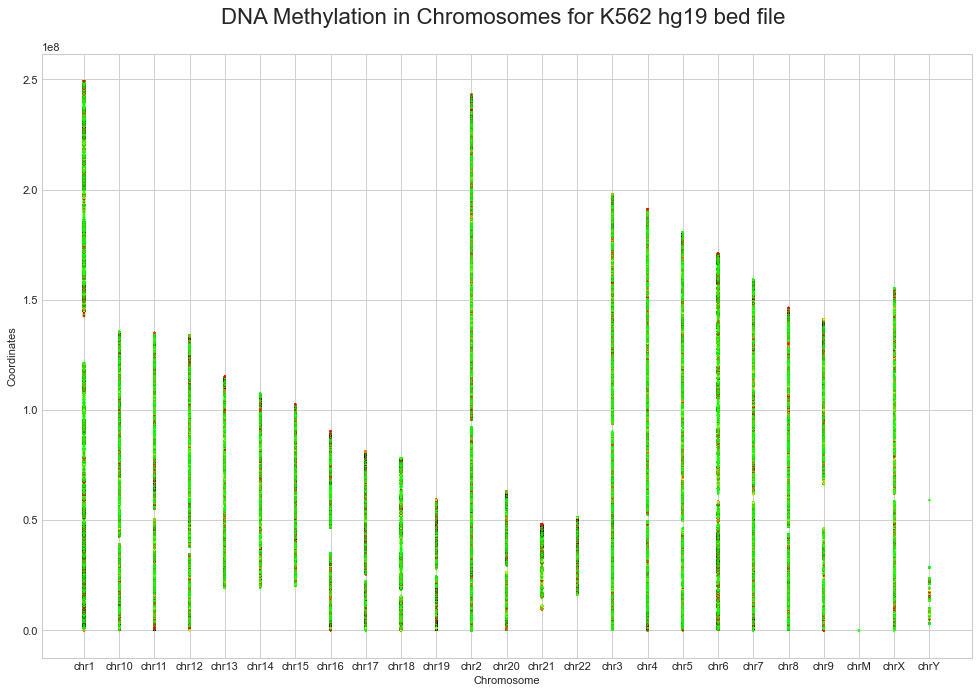

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.style.use('seaborn-whitegrid')

figure(figsize=(15, 10), dpi=80)

plt.scatter(irbs['track'], irbs['name="SL725'], c = col, s = 1)

plt.xlabel('Chromosome')
plt.ylabel('Coordinates')

plt.title('DNA Methylation in Chromosomes for K562 hg19 bed file \n', size = 20)

# plt.axis([-0.3,0.2,10,80])
# plt.savefig('Linear-regression_1.eps', format = 'eps')


Obtain all the RGB color values to plot them

In [276]:
col_keys = irbs['Unnamed: 8'].unique()

for i, x  in enumerate(col_keys):
    col_keys[i] = col_keys[i].split(',')

for i, x  in enumerate(col_keys):
   col_keys[i] = pd.to_numeric(col_keys[i])/255

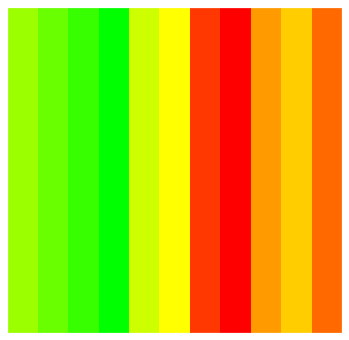

In [544]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.axis(xmin=0, xmax=len(col_keys))
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

for index, colour in enumerate(col_keys):
    ax.axvspan(index, index + 1, color=colour)

#### Show only the methylation position at every basepair in the promoter sequence

Display Conventions and Configuration

Methylation status is represented with an 11-color gradient using the following convention:


- red = 100% of molecules sequenced are methylated

- yellow = 50% of molecules sequenced are methylated

- green = 0% of molecules sequenced are methylated


The score in this track reports the number of sequencing reads obtained for each CpG, which is often called 'coverage'. The score is capped at 1000, so any CpGs that were covered by more than 1000 sequencing reads have a score of 1000. The BED files available for download contain two extra columns: one with the uncapped coverage (number of reads at that site) and one with the percentage of those reads that show methylation. High reproducibility was obtained, with correlation coefficients greater than 0.9 between biological replicates, when only considering CpGs represented by at least 10 sequencing reads (10X coverage, score=10). Therefore, the default view for this track is set to 10X coverage, or a score of 10.

Metadata for a particular subtrack can be found by clicking the down arrow in the list of subtracks.

Description taken from: http://genome.ucsc.edu/cgi-bin/hgFileUi?db=hg19&g=wgEncodeHaibMethylRrbs#TRACK_HTML

Create a vector full of zeros and then fill each position with correspondent position from the 5' Transcription start in Jin's file 

#### Previous work with only one chromosome

In [37]:
# Extract only the Chromosome 1 

chr1_cpgs = irbs[irbs.track == 'chr2']

#Extract only the values with 100% Certainty of methylation 
chr1_cpgs = chr1_cpgs[chr1_cpgs['Unnamed: 8'] == '255,0,0']
chr1_cpgs

# # Extract only the Promoter sequences in Chromosome 1 

# chr1_ps = Promoter_sequences[Promoter_sequences.chromosome == 'chr2']


# chr1_ps = chr1_ps.reset_index()
# chr1_ps

# # tmp = np.zeros((1955,3001))

# # for i, x in enumerate(chr1_cpgs['name="SL725.1'][:20]):
# #     for o, z in enumerate(chr1_ps["Primary TSS, 3'"]):
# #         if (x > (z - 1500) and (x < (z + 1500))) == True:
# #             print('CpG Islands found in:', x,'TSS Starts:', z, 'Position on vector:', x - (z - 1500),"in row", o)
# #             tmp[o][x - (z - 1500)] == 1

# ## For one chromosome

# tmp = np.zeros((len(chr1_ps),3001))

# for i, x in enumerate(chr1_cpgs['name="SL725.1']):


#     np.array()

#     for o, z in enumerate(chr1_ps["Primary TSS, 3'"]):
#         if (x > (z - 1500) and (x < (z + 1500))) == True:

#             y = x - (z - 1500)

#             #print((z - 1500), z,  (z + 1500))
#             #print('CpG Islands found in:', x, 'Position on vector:', y,"in row", chr1_ps['gene'][o], o + 1)    
#             tmp[o + 1][y] = 1

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
670565,chr2,100008792,100008793,K562_Rep3_RRBS,5,-,100008792,100008793,"255,0,0",5,100
670566,chr2,100008798,100008799,K562_Rep3_RRBS,5,-,100008798,100008799,"255,0,0",5,100
670678,chr2,100107194,100107195,K562_Rep3_RRBS,2,+,100107194,100107195,"255,0,0",2,100
670710,chr2,100210292,100210293,K562_Rep3_RRBS,38,-,100210292,100210293,"255,0,0",38,97
670712,chr2,100210298,100210299,K562_Rep3_RRBS,38,-,100210298,100210299,"255,0,0",38,97
...,...,...,...,...,...,...,...,...,...,...,...
753354,chr2,9962378,9962379,K562_Rep3_RRBS,1,-,9962378,9962379,"255,0,0",1,100
753358,chr2,99722074,99722075,K562_Rep3_RRBS,1,+,99722074,99722075,"255,0,0",1,100
753359,chr2,99722091,99722092,K562_Rep3_RRBS,1,+,99722091,99722092,"255,0,0",1,100
753526,chr2,99960677,99960678,K562_Rep3_RRBS,1,+,99960677,99960678,"255,0,0",1,100


### Utilizing all chromosomes

In [37]:
# Obtain the additional column in df as level_0

df = df.reset_index()

In [41]:
#Extract only the values with 100% Certainty of methylation 
irbs = irbs[irbs['Unnamed: 8'] == '255,0,0']
irbs.head()

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
35,chr1,100266424,100266425,K562_Rep3_RRBS,1,-,100266424,100266425,"255,0,0",1,100
36,chr1,100288780,100288781,K562_Rep3_RRBS,1,+,100288780,100288781,"255,0,0",1,100
37,chr1,100301433,100301434,K562_Rep3_RRBS,1,+,100301433,100301434,"255,0,0",1,100
39,chr1,1003026,1003027,K562_Rep3_RRBS,1,+,1003026,1003027,"255,0,0",1,100
40,chr1,1003038,1003039,K562_Rep3_RRBS,1,+,1003038,1003039,"255,0,0",1,100


In [42]:
chromosome_list = np.unique(irbs.track)

#### Change the zeros vector to one for the position of the methylation

In [43]:
tmp = np.zeros((len(df),3001))

for index, chromosomes in enumerate(chromosome_list):
    
    table = irbs[irbs['track'] == chromosomes]
    table2 = df[df.chromosome == chromosomes]

    for i, x in enumerate(table['name="SL725.1']):


        for o, z in enumerate(table2["Primary TSS, 3'"]):

            if (x > (z - 1500) and (x < (z + 1500))) == True:
                y = x - (z - 1500)
                #print((z - 1500), z,  (z + 1500))
                #print('CpG Islands found in:', x, 'Position on vector:', y,"in row", Promoter_sequences['gene'][o], o + 1)    

                tmp[(df.level_0[df["Primary TSS, 3'"] == z ].iloc[-1])][int(y)] = 1

In [44]:
np.unique(np.where(tmp == 1)[0])

array([    0,     4,    17, ..., 18887, 18896, 18899])

A2ML1 | Coordinates of TSS: 8975150.0
Found 4 Methylated basepairs at positions:
[8975608. 8975626. 8975628. 8975688.]
chr12 : 8973650.0 - 8976650.0


4

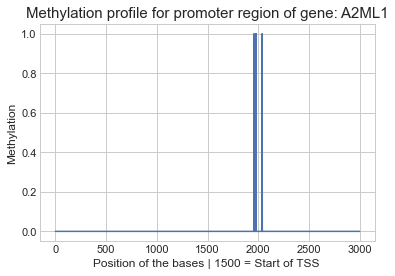

In [231]:
methylated_basepairs(4)

In [228]:
df.iloc[3]

Unnamed: 0                                                                        3.0
Gene                                                                            A2ML1
Sequences                           AAGGATTTAAGTAATAATAAAACTCCAGTCTCCCACACAGCCGGCT...
index                                                                             4.0
gene_x                                                                          A2ML1
transcript                                                                       P1P2
chromosome                                                                      chr12
strand                                                                              +
TSS source                                                        CAGE, matched peaks
Primary TSS, 5'                                                             8975206.0
Primary TSS, 3'                                                             8975150.0
Secondary TSS, 5'                                     

Issue with int 0 Gene:
Issue with int 0 Gene:
error with 0
A2ML1 | Coordinates of TSS: 8975150.0
Found 4 Methylated basepairs at positions:
[8975608. 8975626. 8975628. 8975688.]
chr12 : 8973650.0 - 8976650.0
No Methylated Cs
AAK1 | Coordinates of TSS: 69771371.0
Found 0 Methylated basepairs at positions:
[]
chr2 : 69769871.0 - 69772871.0
AAMDC | Coordinates of TSS: 77532208.0
Found 3 Methylated basepairs at positions:
[77531412. 77531425. 77531439.]
chr11 : 77530708.0 - 77533708.0
AAMP | Coordinates of TSS: 219128852.0
Found 1 Methylated basepairs at positions:
[2.19128048e+08]
chr2 : 219127352.0 - 219130352.0
AARS | Coordinates of TSS: 70323421.0
Found 1 Methylated basepairs at positions:
[70322096.]
chr16 : 70321921.0 - 70324921.0
No Methylated Cs
AARSD1 | Coordinates of TSS: 41107904.0
Found 0 Methylated basepairs at positions:
[]
chr17 : 41106404.0 - 41109404.0
No Methylated Cs
AASS | Coordinates of TSS: 121713598.0
Found 0 Methylated basepairs at positions:
[]
chr7 : 121712098.0 -

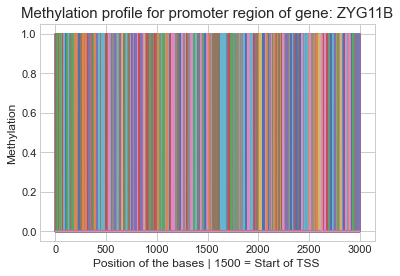

In [47]:
methylated_cs = [methylated_basepairs(i) for i in range(len(df))]

methylated_cs.insert(18902, 0)
methylated_cs.pop(0)

df['Methylated_Cs'] = methylated_cs

#### Correct the wrong C and visualize the vector

In [45]:
## Function to show each position for a certain gene

import matplotlib.pyplot as plt

#### Nilah recommended creating a plot for methylation near TSS (position and its phenotype score)

def methylated_basepairs(int):
    try:
        if len(np.where(tmp[int] == 1)[0]) > 0:
            is_c(int)
            is_c(int)

            x = df.head(int).tail(1)['Gene'].iloc[-1]
            print(x, "| Coordinates of TSS:", df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1])
            print("Found", len([np.where(tmp[int] == 1)][0][0]) , "Methylated basepairs at positions:")
            print([np.where(tmp[int] == 1)][0][0] + df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500)
            plt.title("Methylation profile for promoter region of gene: {}".format(x), size = 15)
            plt.xlabel('Position of the bases | 1500 = Start of TSS ')
            plt.ylabel('Methylation')
            plt.plot(tmp[int])

            #print(df[df['Gene'] == x]["chromosome"].iloc[-1],':',[np.where(tmp[int] == 1)][0][0][0] + df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500, '-', [np.where(tmp[int] == 1)][0][0][0] + df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500 + 1)
            print(df[df['Gene'] == x]["chromosome"].iloc[-1],':', df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500, '-', df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1] + 1500 )

            return(len([np.where(tmp[int] == 1)][0][0]))

            #Uncomment this if its needed are the coordinates of each methylated C
            #return([np.where(tmp[int] == 1)][0][0] + df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1])

        else:
            x = df.head(int).tail(1)['Gene'].iloc[-1]
            #print(x, "| Coordinates of TSS:", df[df['Gene'] == x]["Primary TSS, 3'"].iloc[-1])
            return 0
    except:
        print('error with', int)

In [46]:
# Are the predicted methylation sites C?  

def is_c(int):
    
    counter = 0
    total = 0

    try:
        x = [np.where(tmp[int] == 1)][0][0]
        y = df.head(int).tail(1)['Gene'].iloc[-1]

        if len(x) == 0:
            print("No Methylated Cs")
            
        for i in x:

            total += 1

            if list(df.Sequences[df['Gene'] == y].iloc[-1])[i] == 'C':
                #print(i, 'is a C')
                counter +=1 
            else:
                #print(i, 'is not a C, its a ' + list(df.Sequences[df['Gene'] == y].iloc[-1])[i])
                tmp[int][i] = 0
    except:
        print("Issue with int", int, "Gene:")

    #print('Correct Cs:',counter/total*100,'%')



ValueError: 'c' argument has 2030 elements, which is inconsistent with 'x' and 'y' with size 18902.

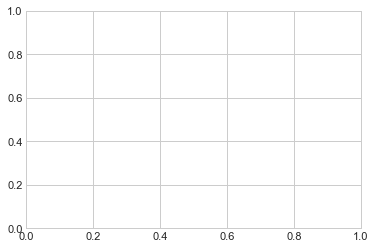

In [249]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression

regression_data = df[['CRISPRoff_average','Methylated_Cs']].dropna()

x =  np.array(regression_data.Methylated_Cs).reshape((-1,1))
y =  np.array(regression_data.CRISPRoff_average)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.Methylated_Cs),y,1)

colors = {1:'tab:pink', 0:'tab:grey'}

# print('coefficient of determination:', r_sq)
# print('slope:', model.coef_)
# print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['Methylated_Cs'],s = 0.1, c = achilles_scores['genes'].map(colors))


plt.title('Linear Regression of Methylated_Cs and Phenotype scores \n', size = 20)
plt.xlabel('CRISPROff Phenotype')
plt.ylabel('Methylated_Cs')
plt.plot(x, m*x + b)

plt.axis([-0.75,0.8,0,100])
plt.savefig('achiles-line.eps', format = 'eps', bbox_inches='tight')


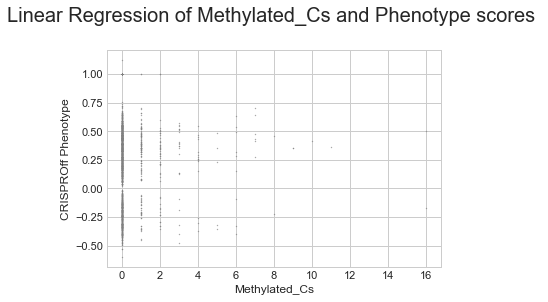

In [50]:
achilles_scores_inner = pd.merge(how = 'inner', left = achilles, right = df, left_on = 'genes', right_on = 'Gene')

# regression_data = achilles_scores_inner[['CRISPRoff_average','Methylated_Cs']].dropna()

# x =  np.array(regression_data.CRISPRoff_average).reshape((-1,1))
# y =  np.array(regression_data.Methylated_Cs)

# print('coefficient of determination:', r_sq)
# print('slope:', model.coef_)
# print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter( achilles_scores_inner['Methylated_Cs'], achilles_scores_inner['Strength'] ,s = 0.1, c = 'grey')

plt.title('Linear Regression of Methylated_Cs and Phenotype scores \n', size = 20)
plt.ylabel('CRISPROff Phenotype')
plt.xlabel('Methylated_Cs')

#plt.axis([-5,20, -0.75,0.2])
plt.savefig('Methylated_Cs and Phenotype Scores.eps', format = 'eps')


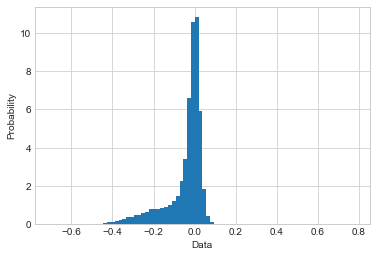

In [75]:
plt.hist(df['CRISPRoff_average'], density=True, bins=80)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

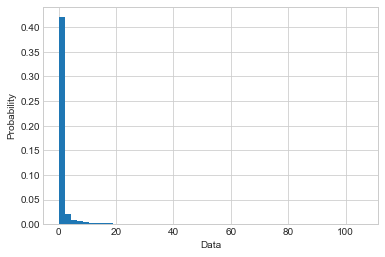

In [74]:
plt.hist(df['Methylated_Cs'], density=True, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

#### Distance to TSS

In [50]:
def methylation_location(int):

    try:
        TSS = df.iloc[int + 1]["Primary TSS, 3'"]
        methy_bp = methylated_basepairs(int) + df.iloc[int + 1]["Primary TSS, 3'"] - 1500

        for methylation in methy_bp:

            print(methylation, TSS )


            if methylation < TSS :
                #print(methylation, 'is outside the TSS at', TSS)
                df['Methylation_outside'][int -1] += 1 
                #print(df['Methylation_outside'])
            elif methylation > TSS:
                #print(methylation, 'is within the TSS at', TSS)
                df['Methylation_insde'][int -1 ] += 1 
                #print(df['Methylation_insde'][int])
            else:
                print('what?')
    except:
        pass
            

In [404]:
df['Methylation_insde'] = 0
df['Methylation_outside'] = 0

for i in range(len(df)):
    methylation_location(i)

Issue with int 0 Gene:
Issue with int 0 Gene:
52601708.0 52601584.0
43114710.0 43114252.0
43114728.0 43114252.0
43114730.0 43114252.0
43114790.0 43114252.0
74462834.0 74463630.0
74462847.0 74463630.0
74462861.0 74463630.0
34823535.0 34824339.0
41106579.0 41107904.0
8767156.0 8768444.0
8767428.0 8768444.0
8767486.0 8768444.0
8769188.0 8768444.0
8769510.0 8768444.0
2374676.0 2373344.0
94512605.0 94511193.0
94512633.0 94511193.0
16044243.0 16043434.0
48249717.0 48250025.0
48249737.0 48250025.0
48249751.0 48250025.0
95818543.0 95818412.0
1877270.0 1876975.0
1877624.0 1876975.0
1877666.0 1876975.0
1877722.0 1876975.0
1877725.0 1876975.0
1877727.0 1876975.0
1877793.0 1876975.0
1877877.0 1876975.0
1877881.0 1876975.0
1878260.0 1876975.0
74479137.0 74480068.0
74479141.0 74480068.0
74479999.0 74480068.0
74480521.0 74480068.0
74480530.0 74480068.0
136131424.0 136130563.0
34172171.0 34172534.0
38165632.0 38164201.0
38165634.0 38164201.0
107991768.0 107992258.0
43209254.0 43209967.0
61562721.0 615

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_65707/1927582586.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Methylation_insde'][int -1 ] += 1
/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_65707/1927582586.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Methylation_outside'][int -1] += 1


 150521898.0
150521894.0 150521898.0
150521924.0 150521898.0
150521930.0 150521898.0
150521939.0 150521898.0
938562.0 937537.0
938567.0 937537.0
938568.0 937537.0
938604.0 937537.0
938679.0 937537.0
29247696.0 29248754.0
29249044.0 29248754.0
1221835.0 1223253.0
78266041.0 78266426.0
78267642.0 78266426.0
145598325.0 145597731.0
25041906.0 25042039.0
31093246.0 31091910.0
31093248.0 31091910.0
31093253.0 31091910.0
3501751.0 3501690.0
75910893.0 75910943.0
75911188.0 75910943.0
75911278.0 75910943.0
50921226.0 50919985.0
50191410.0 50191942.0
50191411.0 50191942.0
50191428.0 50191942.0
50192383.0 50191942.0
50193088.0 50191942.0
49505455.0 49506883.0
49505765.0 49506883.0
49506272.0 49506883.0
49507566.0 49506883.0
49508152.0 49506883.0
49508153.0 49506883.0
49508175.0 49506883.0
49508176.0 49506883.0
49508179.0 49506883.0
49508249.0 49506883.0
49508277.0 49506883.0
49508362.0 49506883.0
15847664.0 15848231.0
15847746.0 15848231.0
15847749.0 15848231.0
112041699.0 112042051.0
112041718

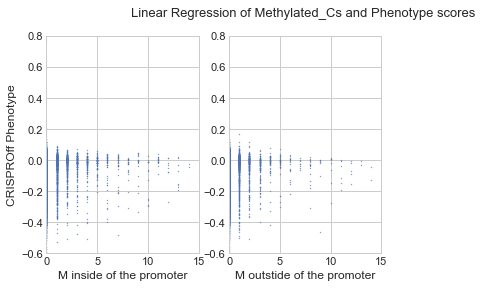

In [441]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression

# regression_data = df[['CRISPRoff_average','Methylation_insde']].dropna()

# x =  np.array(regression_data.Methylation_insde).reshape((-1,1))
# y =  np.array(regression_data.CRISPRoff_average)

# model = LinearRegression()
# model.fit(x,y)
# model = LinearRegression().fit(x,y)
# r_sq = model.score(x, y)

colors = {1:'tab:pink', 0:'tab:grey'}

# print('coefficient of determination:', r_sq)
# print('slope:', model.coef_)
# print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.scatter(df['Methylation_insde'], df['CRISPRoff_average'],s = 0.1, )

plt.ylabel('CRISPROff Phenotype')
plt.xlabel('M inside of the promoter')
plt.axis([0,15,-0.6,0.8])

plt.subplot(1, 2, 2)
plt.scatter( df['Methylation_outside'], df['CRISPRoff_average'],s = 0.1)

plt.axis([0,15,-0.6,0.8])

plt.title('Linear Regression of Methylated_Cs and Phenotype scores \n', size = 13)
plt.xlabel('M outstide of the promoter')
#plt.plot(x, m*x + b)

plt.savefig('achiles-line.eps', format = 'eps', bbox_inches='tight')
